# Begin the modeling process

Objectives
- Train/Validate/Test split
- Cross-Validation
- Begin with baselines

In [30]:
import warnings

# !conda install -c conda-forge category_encoders
import category_encoders as ce #----------------------NEW!
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score #-NEW!
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score #-----------NEW! (more in next notebook)
from sklearn.pipeline import make_pipeline #----------NEW!
from sklearn.preprocessing import StandardScaler

# ignore StandardScaler DataConversionWarning's
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Example: Bank Marketing dataset

Get the dataset:

#### Kaggle
- Download from the [Kaggle competition page](https://www.kaggle.com/c/ds2-model-validation/data)
- Use the Kaggle API

#### GitHub
- Clone the [repo](https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/tree/master/module-1-begin-modeling-process/bank-marketing)

Similar to this dataset: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [1]:
train_features = pd.read_csv('datasets/bank-marketing/train_features.csv')
train_labels = pd.read_csv('datasets/bank-marketing/train_labels.csv')
test_features = pd.read_csv('datasets/bank-marketing/test_features.csv')
# test_labels intentionally withheld
sample_submission = pd.read_csv('datasets/bank-marketing/sample_submission.csv')

train_features.shape, train_labels.shape, test_features.shape, sample_submission.shape

((30891, 20), (30891, 2), (10297, 20), (10297, 2))

In [2]:
train_labels['y'].value_counts(normalize=True)

0    0.887346
1    0.112654
Name: y, dtype: float64

## Train/Test split

In [3]:
y_train = train_labels['y']
X_train = train_features.drop(columns='id')
X_test  = test_features.drop(columns='id')

## Train/Validation/Test split

We simply use [**`sklearn.model_selection.train_test_split`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the training data into **training** and **validation** data.

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((23168, 19), (7723, 19), (23168,), (7723,))

Fit on the training set.

Predict and score with the validation set.

## Majority class baseline

Determine the majority class:

In [5]:
y_train.value_counts(normalize=True)

0    0.886352
1    0.113648
Name: y, dtype: float64

Guess the majority class for every prediction:

In [6]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_val)

#### [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Baseline accuracy by guessing the majority class for every prediction:

In [7]:
accuracy_score(y_val, y_pred)
# almost identical, but not identical because y_val is different than y_train

0.8903275929043118

#### [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

Baseline "ROC AUC" score by guessing the majority class for every prediction. ROC AUC is 0 to 1, always 0.5 if we just guess the majority class. Less than 0.5 means worse than guessing, greater than 0.5 is better than guessing.

In [8]:
roc_auc_score(y_val, y_pred)

0.5

## Fast first models

### Ignore rows/columns with nulls

This dataset doesn't have any nulls:

In [9]:
X_train.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

### Ignore nonnumeric features

Here are the numeric features:

In [10]:
X_train.describe(include=np.number)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000,23168.000000
mean,40.035566,2.566730,961.368180,0.177055,0.076398,93.574613,-40.513031,3.611040,5166.555689
std,10.407186,2.754003,189.616358,0.508049,1.572455,0.579068,4.638444,1.739444,72.836489
min,17.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Here are the nonnumeric features:

In [11]:
X_train.describe(exclude=np.number)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,23168,23168,23168,23168,23168,23168,23168,23168,23168,23168
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,5827,13963,6756,18235,12131,19039,14771,7702,4844,19970


Just select the nonnumeric features:

In [12]:
X_train_numeric = X_train.select_dtypes(np.number)
X_val_numeric = X_val.select_dtypes(np.number)

In [13]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_numeric, y_train)

y_pred = model.predict_proba(X_val_numeric)[:, 1]
roc_auc_score(y_val, y_pred)

0.7416251314395055

### With Scaler

In [14]:
scaler = StandardScaler()
# fit to AND transform train data
X_train_scaled = scaler.fit_transform(X_train_numeric)
# do not fit, only transform validation data
X_val_scaled = scaler.transform(X_val_numeric)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict_proba(X_val_scaled)[:, 1]
roc_auc_score(y_val, y_pred)

0.7467503277831693

### Same, as a pipeline

In [15]:
pipeline = make_pipeline(
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipeline.fit(X_train_numeric, y_train)


y_pred = pipeline.predict_proba(X_val_numeric)[:, 1]

# may not match exactly due to random state
roc_auc_score(y_val, y_pred)

0.7467503277831693

### Encode "low cardinality" categoricals

One-hot encode the "low cardinality" categoricals

In [16]:
X_train.select_dtypes(exclude=np.number).nunique()

job            12
marital         4
education       8
default         3
housing         3
loan            3
contact         2
month          10
day_of_week     5
poutcome        3
dtype: int64

In [17]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7773208731085933

### Generate Submission

In [18]:
submission = sample_submission.copy()
submission['y'] = pipeline.predict_proba(X_test)[:, 1:]

In [20]:
submission.to_csv('datasets/bank-marketing/submission-001.csv', index=False)

# Baseline with cross-validation + independent test set
A complete example, as an alternative to Train/Validate/Test


#### scikit-learn documentation
- [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
- [ The `scoring` parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)

In [28]:
# Load data
X_train = pd.read_csv('datasets/bank-marketing/train_features.csv').drop(columns='id')
X_test  = pd.read_csv('datasets/bank-marketing/test_features.csv').drop(columns='id')
y_train = pd.read_csv('datasets/bank-marketing/train_labels.csv')['y']
sample_submission = pd.read_csv('datasets/bank-marketing/sample_submission.csv')

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

# Cross-validation with training data
cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    7.2s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.9s finished


array([0.77295183, 0.78574708, 0.78036636, 0.79742952, 0.79020263,
       0.79837252, 0.79259604, 0.80331817, 0.77434981, 0.78202959])

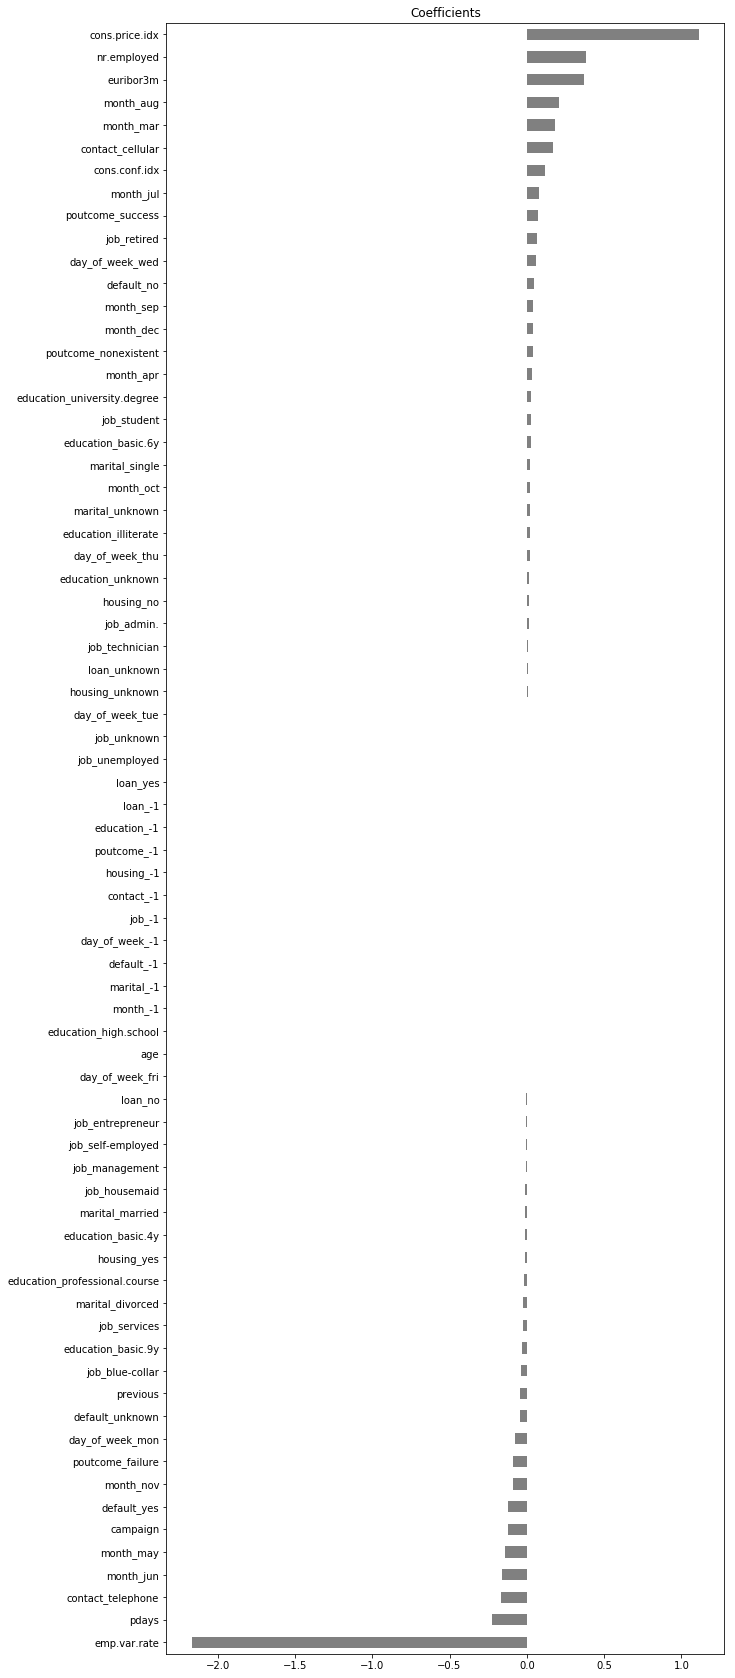

In [31]:
# (Re)fit on training data
pipeline.fit(X_train, y_train)

# Generate submission
submission = sample_submission.copy()
submission['y'] = pipeline.predict_proba(X_test)[:, 1]
submission.to_csv('submission-001.csv', index=False)

# Visualize coefficients
plt.figure(figsize=(10,30))
plt.title('Coefficients')
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');